# Classification
## MNIST

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

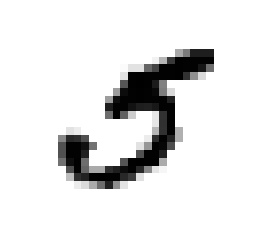

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [5]:
y[36000]

5.0

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

In the book sample #36000 is recognized as a five, but not here?

## Performance Measures
### Measuring Accuracy Using Cross-Validation

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.9627 ,  0.96665,  0.94805])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.91285,  0.90875,  0.90735])

### Confusion Matrix

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53345,  1234],
       [ 1218,  4203]])

### Precision and Recall

In [16]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.77303660106676475

In [17]:
recall_score(y_train_5, y_train_pred)

0.77531820697288323

In [18]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.77417572296923931

### Precision/Recall Traceoff

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 137855.76109862])

In [20]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

In [21]:
threshold = -40000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

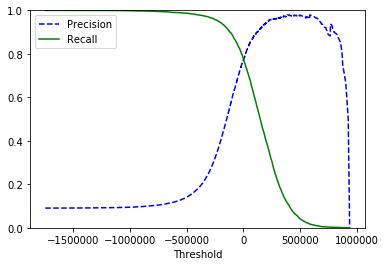

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [25]:
y_train_pred_90 = (y_scores > 150000)

precision_score(y_train_5, y_train_pred_90)

0.91709314227226202

In [26]:
recall_score(y_train_5, y_train_pred_90)

0.49584947426674048

### The ROC Curve

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

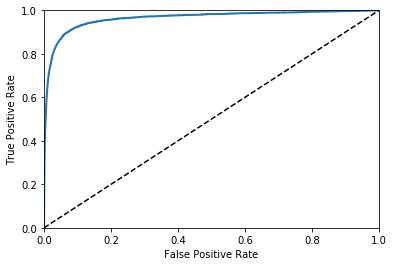

In [28]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.96403303556580533

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [31]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

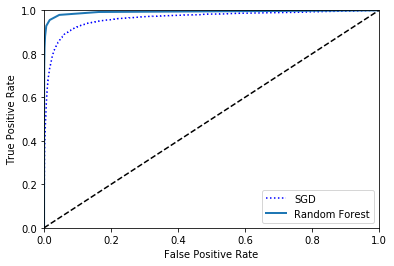

In [32]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [33]:
roc_auc_score(y_train_5, y_scores_forest)

0.99269019389513979

## Multiclass Classification

In [34]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [35]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-179909.96190954, -349571.63281952, -372973.15185377,
        -239921.23913593, -514495.39681724,  137855.76109862,
        -672060.50523789, -400660.621955  , -703172.76157855,
        -819951.49753376]])

In [36]:
np.argmax(some_digit_scores)

5

In [37]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [38]:
sgd_clf.classes_[3]

3.0

In [39]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [40]:
len(ovo_clf.estimators_)

45

In [41]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [42]:
forest_clf.predict_proba([some_digit])

array([[ 0. ,  0. ,  0. ,  0.2,  0. ,  0.8,  0. ,  0. ,  0. ,  0. ]])

In [43]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([ 0.84083183,  0.86469323,  0.84347652])

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([ 0.90941812,  0.91014551,  0.90953643])

## Error Analysis

In [45]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5739,    2,   22,   12,    9,   44,   43,   10,   38,    4],
       [   2, 6484,   46,   24,    6,   43,    6,   14,  108,    9],
       [  55,   35, 5318,  106,   81,   25,  101,   63,  159,   15],
       [  47,   40,  133, 5370,    5,  218,   31,   64,  134,   89],
       [  19,   29,   32,    7, 5392,   10,   56,   34,   83,  180],
       [  80,   41,   33,  198,   77, 4575,  105,   29,  193,   90],
       [  34,   24,   45,    1,   41,   87, 5628,    6,   51,    1],
       [  23,   22,   66,   31,   54,    8,    5, 5850,   18,  188],
       [  55,  167,   65,  158,   13,  142,   59,   35, 5027,  130],
       [  41,   38,   24,   94,  190,   41,    2,  239,   81, 5199]])

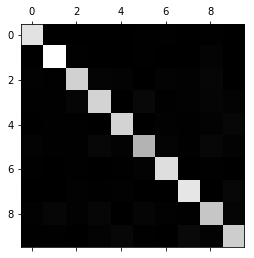

In [46]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [47]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

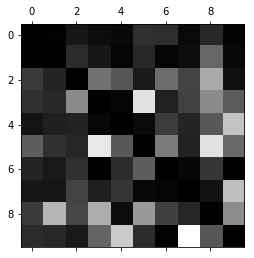

In [48]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Multilabel Classification

In [49]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [50]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [51]:
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score(y_multilabel, y_train_knn_pred, average='macro')

## Multioutput Classification

In [52]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [53]:
def plot_digit(digit):
    image = digit.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary, interpolation='nearest')
    plt.axis('off')
    plt.show()

In [54]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

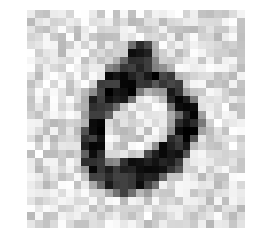

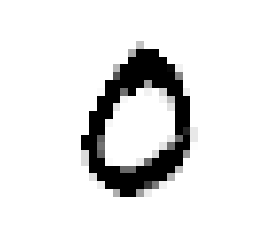

In [55]:
noisy_digit = X_test_mod[0]
plot_digit(noisy_digit)

clean_digit = knn_clf.predict([noisy_digit])
plot_digit(clean_digit)